Question 01

Parameters of the largest circle:
Radius: 49.49747468305833 pixels
Center coordinates: ( 0.0 , 239.0 )
Sigma range used: from 2 to 35


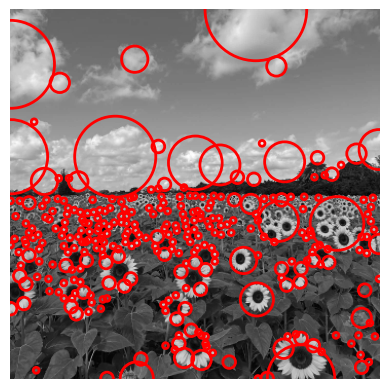

In [32]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log

# Load the image
im = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
# Convert the image to grayscale
gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY) 

# Blob detection
blobs = blob_log(gray_im, min_sigma=2, max_sigma=35, num_sigma=15, threshold=.1)
a = max(blobs[:, 2])
blobs[:, 2] = blobs[:, 2] * math.sqrt(2)
b = max(blobs[:, 2])
x0, y0, r = blobs[np.where(blobs[:, 2] == b)[0][0]]

# Plot the image
fig, ax = plt.subplots()
ax.imshow(gray_im, cmap='gray')
ax.axis('off')

# Plot all blobs
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

print("Parameters of the largest circle:")
print("Radius:", b, "pixels")
print("Center coordinates: (", x0, ",", y0, ")")
print("Sigma range used: from 2 to 35")
plt.show()


Question 02

implementing RANSAC Line

iteration 1
line_best_error 13.685547170130393
best_line_indices [35 73]
best_line_model [0.7202774  0.69368615 1.25790582]
no of inliers 45

iteration 11
line_best_error 12.681810376488086
best_line_indices [71 94]
best_line_model [0.7089728  0.70523583 1.16504499]
no of inliers 44

iteration 50
line_best_error 10.864021002871974
best_line_indices [62 72]
best_line_model [0.69793249 0.71616356 1.50672484]
no of inliers 41

implementing RANSAC Circle


no of elements in X 100
no of inliers 41
remnants 59

iteration 0
best_error 8.173303259629073
best_indecies [30 28  8]
best_model [ 2.42296776  2.91712324 10.01899624]
no of inliers 36

iteration 24
best_error 4.889511676103383
best_indecies [47 12 21]
best_model [2.09529674 2.75681563 9.97854684]
no of inliers 37


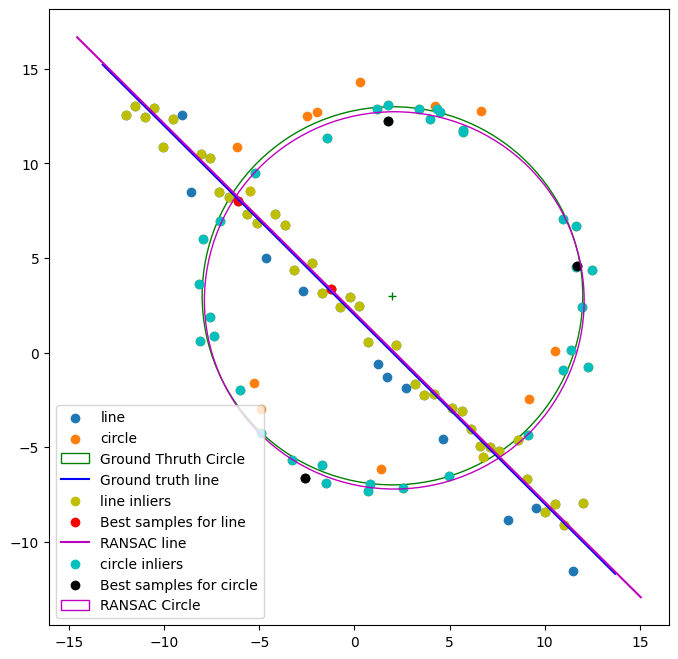

In [34]:
# Generation of a Noisy Point Set Conforming to a Line and a Circl e
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace(-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig , ax = plt.subplots (1 ,1 , figsize=(8 ,8))
ax . scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label = 'circle')
circle_get = plt.Circle( ( x0_gt , y0_gt ) , r , color = 'g', fill=False , label='Ground Thruth Circle' )
ax . add_patch (circle_get)
ax . plot ( ( x0_gt ) , ( y0_gt ) ,'+', color = 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot ( x_ , y_ ,color = 'b' , label= 'Ground truth line' )
plt.legend ( )


#implementing RANSAC Line

N = X.shape[0]  # number of points
X = X # data matrix
print('implementing RANSAC Line')

#total least square erorr for line
def line_total_error(x,line_indices):
    a,b,d = x[0],x[1],x[2]
    return np.sum(np.square(a*X[line_indices,0]+b*X[line_indices,1]-d))

#constraint
def cons(x):
    return x[0]**2+x[1]**2-1

constraint = ({'type':'eq','fun':cons})

#consensus set
def line_consensus_set(X,x,line_threshold):
    a,b,d = x[0],x[1],x[2]
    error = np.abs(a*X[:,0]+b*X[:,1]-d)
    return error<line_threshold

line_max_iterartion = 100
line_threshold = 1.
line_data_points = 0.4*N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
line_inlinears = []
best_line_inliers = []   
line_iteration = 0

while line_iteration< line_max_iterartion:
    line_indices = np.random.randint(0,N,line_sample)  #randomly select s points
    x0 = np.array([1,1,0]) #initial guess
    res = minimize(line_total_error,x0=x0,args=(line_indices),tol= 1e-6,constraints=constraint) #minimize the error
    line_inlinears = line_consensus_set(X,res.x,line_threshold)  #find the consensus set
    if np.sum(line_inlinears) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inlinears),tol= 1e-6, constraints=constraint) #refit the model
        if res.fun < line_best_error:
            print('\niteration',line_iteration)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inlinears
            print('line_best_error',line_best_error)
            print('best_line_indices',best_line_indices)
            print('best_line_model',best_line_model)
            print('no of inliers',np.sum(best_line_inliers))

    line_iteration+= 1

ax.scatter(X[best_line_inliers,0],X[best_line_inliers,1],color='y',label='line inliers')
ax.scatter(X[best_line_indices,0],X[best_line_indices,1],color='r',label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1]*x_ + best_line_model[2])/best_line_model[1]
plt.plot(x_, y_, color ='m', label='RANSAC line')
ax.legend()


#implementing RANSAC Circle
print('\nimplementing RANSAC Circle')
print('\n')
print('no of elements in X',len(X))
print('no of inliers',np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants',len(remnants))

def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

def circle_consenus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < circle_threshold

circle_threshold = 1.
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indecies = []
circle_iteration = 0
circle_sample =3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indicies = np.random.randint(0,len(remnants), circle_sample)
    x0 = np.array([0,0,0]) #initial guess
    res = minimize(circle_tls, x0, args=circle_indicies, tol=1e-6) #minimize the error
    circle_inliers = circle_consenus_set(remnants, res.x, circle_threshold)  #find the consensus set


    if np.sum(circle_inliers) > circle_num_data:
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers),tol= 1e-6)
            if res.fun < circle_best_error:
                print('\niteration',circle_iteration)
                circle_best_error = res.fun
                circle_best_indecies = circle_indicies
                circle_best_model = res.x
                circle_best_inliers = circle_inliers
                print('best_error',circle_best_error)
                print('best_indecies',circle_best_indecies)
                print('best_model',circle_best_model)
                print('no of inliers',np.sum(circle_best_inliers))
                # best_model = res.x
                # best_inliers = inliers
                # best_indecies = indices
    circle_iteration += 1


ax.scatter(remnants[circle_best_inliers,0],remnants[circle_best_inliers,1],color='c',label='circle inliers')
ax.scatter(remnants[circle_best_indecies,0],remnants[circle_best_indecies,1],color='k',label='Best samples for circle')
circle = plt.Circle((circle_best_model[0],circle_best_model[1]),circle_best_model[2],color='m',fill=False,label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()

Question 03

Image shape: (768, 1024, 3)
Flag shape: (320, 640, 3)
Selected Points: [(150, 206), (134, 519), (520, 291), (522, 517)]
Homography matrix:
 [[-3.51282757e-02  1.78110746e+00  1.50000000e+02]
 [ 4.49834328e-01  6.15304845e-01  2.06000000e+02]
 [-7.55841468e-05  1.20164895e-03  1.00000000e+00]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


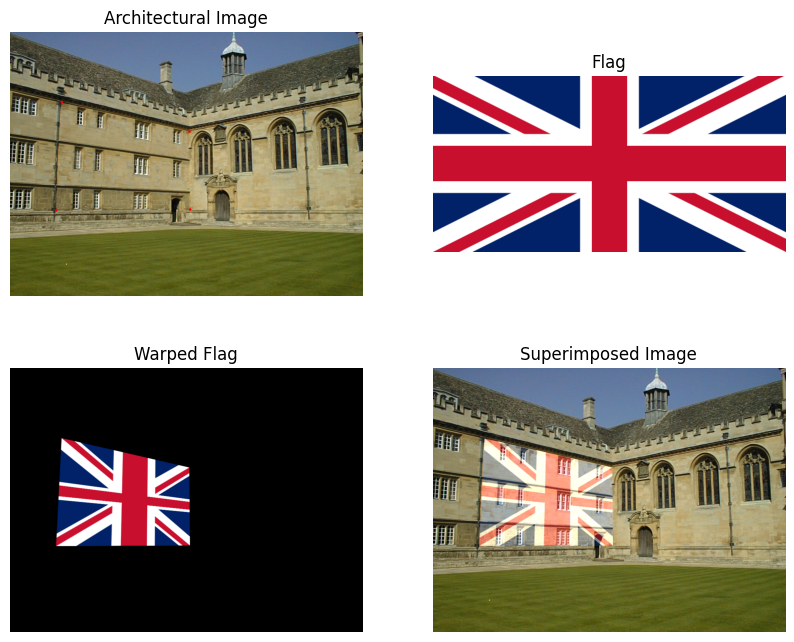

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv2.circle(architectural_image_copy, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow('Image', architectural_image_copy)

# Load the architectural image and the flag
architectural_image = cv2.imread('001.jpg')
flag = cv2.imread('640px-Flag_of_the_United_Kingdom_(1-2).svg.png')

# Make a copy of the architectural image to avoid modifying the original
architectural_image_copy = architectural_image.copy()

# Convert images to float32 and normalize
architectural_image = architectural_image.astype(np.float32) / 255.0
flag = flag.astype(np.float32) / 255.0

# Print image shapes
print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

cv2.imshow('Image', architectural_image_copy)
cv2.setMouseCallback('Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

print("Selected Points:", selected_points)

# Define destination and source points for perspective transformation
dst_points = np.array(selected_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Compute the perspective transformation matrix (homography)
H = cv2.getPerspectiveTransform(src_points, dst_points)
print('Homography matrix:\n', H)

# Warp the flag image using the homography matrix
flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))

# Superimpose the warped flag onto the architectural image
superimposed_image = cv2.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)

# Display the images using matplotlib
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(architectural_image_copy, cv2.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(flag, cv2.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(flag_warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.show()


Question 04

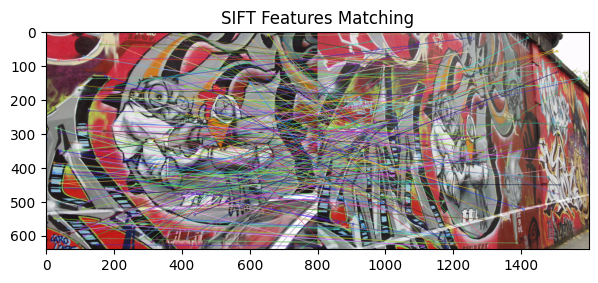

In [36]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load the input images
image1 = cv.imread("img1.ppm")
image5 = cv.imread("img5.ppm")

# Create a SIFT (Scale-Invariant Feature Transform) object
sift = cv.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image5, None)

# Perform feature matching using Brute-Force Matcher
bf_matcher = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = sorted(bf_matcher.match(descriptors1, descriptors2), key=lambda x: x.distance)

# Draw matches between the images
matched_image = cv.drawMatches(image1, keypoints1, image5, keypoints2, matches[:250], image5, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features using matplotlib
fig, ax = plt.subplots(figsize=(7, 7))
matched_image_rgb = cv.cvtColor(matched_image, cv.COLOR_BGR2RGB)
ax.set_title("SIFT Features Matching")
ax.imshow(matched_image_rgb)
plt.show()


Computed Homography =  [[ 6.25782487e-01  5.53812205e-02  2.23100245e+02]
 [ 2.21162950e-01  1.16313125e+00 -2.69842912e+01]
 [ 4.89542882e-04 -4.29298593e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



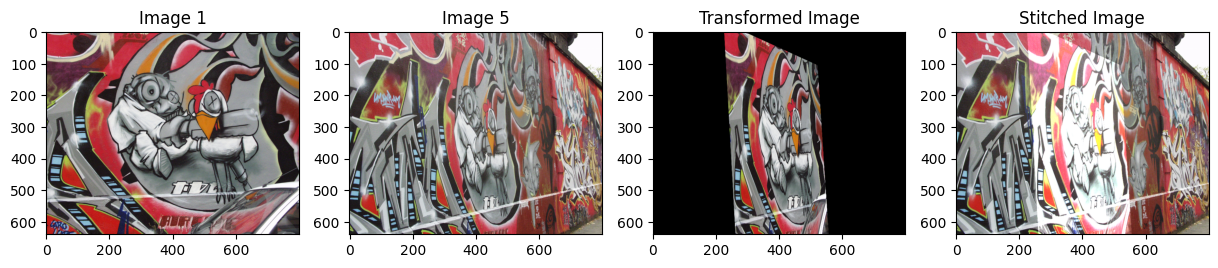

In [37]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale images
image1_gray = cv.cvtColor(cv.imread("img1.ppm"), cv.COLOR_BGR2GRAY)
image2_gray = cv.cvtColor(cv.imread("img2.ppm"), cv.COLOR_BGR2GRAY)
image3_gray = cv.cvtColor(cv.imread("img3.ppm"), cv.COLOR_BGR2GRAY)
image4_gray = cv.cvtColor(cv.imread("img4.ppm"), cv.COLOR_BGR2GRAY)
image5_gray = cv.cvtColor(cv.imread("img5.ppm"), cv.COLOR_BGR2GRAY)

# Create a list of grayscale images
gray_images = [image1_gray, image2_gray, image3_gray, image4_gray, image5_gray]

def calculate_homography(source_points, destination_points):
    # Function to calculate homography matrix given corresponding points
    x1, y1, x2, y2, x3, y3, x4, y4 = destination_points[0], destination_points[1], destination_points[2], destination_points[3], destination_points[4], destination_points[5], destination_points[6], destination_points[7]
    x1T, x2T, x3T, x4T = source_points[0], source_points[1], source_points[2], source_points[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T, x1T, -y1 * x1T), axis=1),
                              np.concatenate((x1T, zero_matrix.T, -x1 * x1T), axis=1),
                              np.concatenate((zero_matrix.T, x2T, -y2 * x2T), axis=1),
                              np.concatenate((x2T, zero_matrix.T, -x2 * x2T), axis=1),
                              np.concatenate((zero_matrix.T, x3T, -y3 * x3T), axis=1),
                              np.concatenate((x3T, zero_matrix.T, -x3 * x3T), axis=1),
                              np.concatenate((zero_matrix.T, x4T, -y4 * x4T), axis=1),
                              np.concatenate((x4T, zero_matrix.T, -x4 * x4T), axis=1)), axis=0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T) @ matrix_A))
    temph = v[:, np.argmin(W)]
    H = temph.reshape((3, 3))
    return H

def generate_random_numbers(n, t):
    # Function to generate random numbers between 0 and n-1 without repetition
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))

    for i in range(len(l)):
        m[i] = np.sum(l == l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return generate_random_numbers(n, t)

confidence = 0.99  
subset_size = 4  
epsilon = 0.5   

# Compute the number of RANSAC iterations needed
num_iterations = int(np.ceil(np.log(1 - confidence) / np.log(1 - ((1 - epsilon) ** subset_size))))
homographies = []
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(gray_images[i], None)  # SIFT feature detection
    key_points_2, descriptors_2 = sift.detectAndCompute(gray_images[i + 1], None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  # Feature matching
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key=lambda x: x.distance)

    source_points = [key_points_1[k.queryIdx].pt for k in matches]
    destination_points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_homography = 2, 0, 0

    for _ in range(num_iterations):
        random_subset_indices = generate_random_numbers(len(source_points) - 1, 4)
        random_subset_source = []
        random_subset_destination = []

        for j in range(4):
            random_subset_source.append(np.array([[source_points[random_subset_indices[j]][0],
                                                  source_points[random_subset_indices[j]][1], 1]]))
            random_subset_destination.append(destination_points[random_subset_indices[j]][0])
            random_subset_destination.append(destination_points[random_subset_indices[j]][1])

        H = calculate_homography(random_subset_source, random_subset_destination)

        inliers = 0
        for k in range(len(source_points)):
            X = [source_points[k][0], source_points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0] - destination_points[k][0], 2) + np.power(HX[1] - destination_points[k][1], 2))
            if err < threshold:
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_homography = H

    homographies.append(best_homography)

H1_to_H5 = homographies[3] @ homographies[2] @ homographies[1] @ homographies[0]
H1_to_H5 /= H1_to_H5[-1][-1]

print("Computed Homography = ", H1_to_H5)
print("Provided Homography = ", open("H1to5p", 'r').read())

transformed_image1 = cv.warpPerspective(cv.imread("img1.ppm"), H1_to_H5, (np.shape(cv.imread("img5.ppm"))[1], np.shape(cv.imread("img5.ppm"))[0]))
stitched_image = cv.add(cv.imread("img5.ppm"), transformed_image1)

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(cv.cvtColor(cv.imread("img1.ppm"), cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(cv.imread("img5.ppm"), cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_image1, cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()
